In [54]:
import fitz  # PyMuPDF
import re
import spacy
import pymupdf
from sklearn.feature_extraction.text import TfidfVectorizer
import string


In [2]:
import pymupdf # imports the pymupdf librar
doc = pymupdf.open("C:/Users/marni/Desktop/AI_Project/PMBOK 7th Edition (iBIMOne.com).pdf") # open a document
for page in doc: # iterate the document pages
  text = page.get_text() # get plain text encoded as UTF-8

In [2]:
# /data_preprocessing.py



# Load spaCy NLP model
nlp = spacy.load('en_core_web_lg')

# Function to extract text from PDF using PyMuPDF
def extract_text_pymupdf(pdf_path):
    text = ""
    try:
        # Open the PDF
        pdf_document = fitz.open(pdf_path)
        
        # Iterate through the pages
        for page_num in range(29,349):
            page = pdf_document.load_page(page_num)
            text += page.get_text()  # Extract text from the page
        
        pdf_document.close()
    except Exception as e:
        print(f"Error reading the PDF file: {e}")
    return text

# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and process with spaCy NLP model
    doc = nlp(text)
    
    # Remove stop words and lemmatize the tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return tokens

# Example usage
# pdf_path = 'C:/Users/marni/Desktop/AI_Project/PMBOK 7th Edition (iBIMOne.com).pdf'
# raw_text = extract_text_pymupdf(pdf_path)
# cleaned_tokens = preprocess_text(raw_text)

# # Output first few cleaned tokensS
# print(cleaned_tokens[:50])


['\n', 'introduction', '\n', 'standard', 'project', 'management', 'identify', 'project', 'management', 'principle', 'guide', '\n', 'behavior', 'action', 'project', 'professional', 'stakeholder', 'work', 'engage', '\n', 'project', '\n', 'introductory', 'section', 'describe', 'purpose', 'standard', 'define', 'key', 'term', '\n', 'concept', 'identify', 'audience', 'standard', '\n', 'standard', 'project', 'management', 'consist', 'follow', 'section', '\n\t\n', 'section', ' ', 'introduction', '\n\t\n', 'section', ' ', 'system']


In [70]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\[.*?\]', '', text)  # Remove references
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with digits
    text = re.sub('http\S+\s', ' ', text)
    
    # Tokenize, lemmatize, and remove stop words using spaCy
    doc = nlp(text)
    
    # Return lemmatized tokens that are not stop words or punctuations
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return tokens

<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
C:\Users\marni\AppData\Local\Temp\ipykernel_13888\538906649.py:9: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('http\S+\s', ' ', text)


In [56]:
# Step 3a: Part-of-Speech Tagging and Chunking (Noun Phrases Extraction)
def extract_noun_chunks(text):
    doc = nlp(text)  # Process the text with spaCy NLP model
    
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]  # Extract noun chunks (noun phrases)
    
    return noun_chunks

In [57]:
# Step 3b: Named Entity Recognition (NER) - Extract named entities like roles, risks, issues, etc.
def extract_named_entities(text):
    doc = nlp(text)  # Process the text with spaCy NLP model
    
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities and their labels
    
    return named_entities


In [58]:
# Step 3c: Relationship Extraction (Subject-Verb-Object)
def extract_relations(text):
    doc = nlp(text)  # Process the text with spaCy NLP model
    
    relations = []
    for token in doc:
        # Extract subject-verb-object relations based on syntactic dependencies
        if token.dep_ == "ROOT":  # Verbs usually have the dependency 'ROOT'
            subject = [w for w in token.lefts if w.dep_ == "nsubj"]  # Subject (nsubj)
            object_ = [w for w in token.rights if w.dep_ == "dobj"]  # Object (dobj)
            if subject and object_:
                relations.append((subject[0].text, token.text, object_[0].text))  # (subject, verb, object)
    
    return relations

In [67]:
def remove_proper_nouns(text):
    doc = nlp(text)  # Process the text with spaCy NLP model
    
    filtered_tokens = []
    for token in doc:
        # Exclude named entities (proper nouns) that are labeled as PERSON or ORG (organizations)
        if token.ent_type_ not in ['PERSON', 'ORG','DATE','GPE','ORDINAL']:  # You can add other entity types to exclude
            filtered_tokens.append(token.lemma_)
    
    return filtered_tokens

In [60]:
# Step 4: Calculate Term Frequency-Inverse Document Frequency (TF-IDF)
def calculate_tfidf(text):
    # Initialize the TfidfVectorizer from scikit-learn
    vectorizer = TfidfVectorizer(stop_words='english')  # Use built-in English stopwords
    
    # Fit the vectorizer on the provided text and transform it into TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([text])
    
    # Get the feature names (terms) and their corresponding TF-IDF scores
    terms = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]  # Extract the TF-IDF scores as a numpy array
    
    # Combine terms with their TF-IDF scores into a dictionary
    tfidf_dict = dict(zip(terms, tfidf_scores))
    
    # Sort the dictionary by TF-IDF scores in descending order
    sorted_tfidf = sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_tfidf

In [78]:
# Step 5d: Filter relations that only involve the top concepts
def filter_relations_by_top_concepts(relations, top_concepts):
    # Get the top concept terms from the TF-IDF results
    top_concept_terms = set([concept for concept, _ in top_concepts])
    
    # Filter relations where both the subject and object are in the top concepts
    filtered_relations = []
    for subject, verb, object_ in relations:
        if subject in top_concept_terms and object_ in top_concept_terms:
            filtered_relations.append((subject, verb, object_))
    
    return filtered_relations

In [71]:
pdf_path = 'C:/Users/marni/Desktop/AI_Project/PMBOK 7th Edition (iBIMOne.com).pdf'

# Step 1: Extract raw text from the PDF
raw_text = extract_text_pymupdf(pdf_path)

# Step 2: Preprocess the text (tokenization, normalization, lemmatization)
cleaned_tokens = preprocess_text(raw_text)

# Join tokens back into text for further NLP tasks
processed_text = ' '.join(cleaned_tokens)

In [72]:
doc = nlp(processed_text)
print(doc[:50])


 introduction 
 standard project management identify project management principle guide 
 behavior action project professional stakeholder work engage 
 project 
 introductory section describe purpose standard define key term 
 concept identify audience standard 
 standard project management consist follow section 
	
 section   introduction 
	
 section   system


In [73]:
# Step 3a: Extract noun phrases (concept candidates)
noun_phrases = extract_noun_chunks(processed_text)
print("Noun Phrases (Concept Candidates):")
print(noun_phrases[:20])  # Print first 20 noun phrases

Noun Phrases (Concept Candidates):
['\n introduction \n standard project management', 'project management principle guide \n behavior action project', 'professional stakeholder work', 'project', 'introductory section', 'purpose standard', 'key term \n concept', 'audience standard \n standard project management', 'follow section \n\t\n section   introduction \n\t\n section   system value delivery \n\t\n section   project management principle \n\u2002  purpose standard project management \n standard project management', 'basis understand', 'project management', 'intend outcome standard', 'regardless industry location size \n delivery approach example', 'system \n project operate', 'key term concept', 'progression profession organization', 'project', 'outcome addition output artifact project manager', 'project', 'value organization stakeholder \n organization system value delivery follow term']


In [74]:
# Step 3b: Extract named entities
re_processed_text = remove_proper_nouns(processed_text)
re_processed_text = ' '.join(re_processed_text)
named_entities = extract_named_entities(re_processed_text)
print("\nNamed Entities:")
print(named_entities[:50])  # Print first 20 named entities


Named Entities:
[('democratic', 'NORP'), ('one', 'CARDINAL'), ('failfastlearn quickly', 'ORG'), ('appropri', 'NORP'), ('american', 'NORP'), ('processbase standard \n  ', 'ORG'), ('pmistandard \n  ', 'ORG'), ('million', 'CARDINAL'), ('responsi \n  ble', 'PERSON'), ('one', 'CARDINAL'), ('selfmanagement selfmanagement', 'PERSON'), ('people decisionmake process increase', 'ORG'), ('devop', 'ORG'), ('proofofconcept development \n  ', 'ORG'), ('week', 'DATE'), ('month year', 'DATE'), ('hundred', 'CARDINAL'), ('thousand', 'CARDINAL'), ('sunday', 'DATE'), ('monday', 'DATE'), ('tuesday', 'DATE'), ('wednesday', 'DATE'), ('thursday', 'DATE'), ('friday', 'DATE'), ('saturday', 'DATE'), ('jim \n  ', 'PERSON'), ('jan \n  ', 'PERSON'), ('inscope', 'PERSON'), ('timeconstraine \n  ', 'ORG'), ('vdo', 'ORG'), ('one', 'CARDINAL'), ('ken blanchards', 'PERSON'), ('browaey', 'NORP'), ('park gulf', 'LOC'), ('one', 'CARDINAL'), ('wellbee', 'ORG'), ('adkar', 'PRODUCT'), ('adkar', 'PRODUCT'), ('decisionmake', 'P

In [76]:
# Step 3c: Extract subject-verb-object relations (relationships between concepts)
relations = extract_relations(re_processed_text)
print("\nExtracted Relations (Subject-Verb-Object):")
print(relations[:50])  # Print first 10 relations


Extracted Relations (Subject-Verb-Object):
[('management', 'identify', 'project'), ('section', 'describe', 'standard'), ('benefit', 'include', 'model'), ('entity', 'accountable', 'team'), ('interact', 'react', 'help'), ('influence', 'undermine', 'perception'), ('skill', 'maintain', 'project'), ('coordination', 'perform', 'resiliency'), ('response', 'optimize', 'threshold'), ('system', 'enable', 'project'), ('stakeholder', 'require', 'skill'), ('person', 'feel', 'chart'), ('decision', 'make', 'time'), ('style', 'include', 'experience'), ('component', 'deliver', 'project'), ('cycle', 'refer', 'approach'), ('volatility', 'change', 'project'), ('project', 'use', 'method'), ('method', 'represent', 'repetition'), ('adjust', 'assume', 'estimate'), ('finish', 'determine', 'task'), ('result', 'indicate', 'picture'), ('statement', 'identify', 'criterion'), ('criterion', 'require', 'deliverable'), ('lead', 'define', 'risk'), ('chart', 'combine', 'know'), ('threshold', 'predict', 'help'), ('base'

In [80]:
# Step 4: Calculate TF-IDF scores for the processed text
filtered_text = ' '.join(remove_proper_nouns(processed_text))

tfidf_scores = calculate_tfidf(filtered_text)
# Output the top 20 terms with the highest TF-IDF scores (most relevant terms)
print("Top 20 terms by TF-IDF score:")
print(len(tfidf_scores))
for term, score in tfidf_scores[:100]:
    print(f"{term}: {score:.4f}")

Top 20 terms by TF-IDF score:
3979
project: 0.7620
team: 0.2460
work: 0.1524
management: 0.1350
pmp: 0.1234
performance: 0.1223
stakeholder: 0.1136
product: 0.1003
change: 0.0985
value: 0.0979
edition: 0.0976
approach: 0.0930
process: 0.0916
risk: 0.0855
plan: 0.0852
outcome: 0.0834
organization: 0.0811
deliverable: 0.0753
domain: 0.0727
include: 0.0724
information: 0.0704
activity: 0.0664
delivery: 0.0664
cost: 0.0617
time: 0.0591
section: 0.0585
development: 0.0565
need: 0.0553
requirement: 0.0539
environment: 0.0530
guide: 0.0530
method: 0.0519
business: 0.0501
cycle: 0.0472
model: 0.0464
life: 0.0449
program: 0.0440
identify: 0.0435
measure: 0.0435
schedule: 0.0432
member: 0.0429
people: 0.0417
estimate: 0.0411
pmbok: 0.0411
use: 0.0411
provide: 0.0406
deliver: 0.0397
standard: 0.0397
tailor: 0.0391
quality: 0.0388
result: 0.0365
planning: 0.0356
benefit: 0.0353
impact: 0.0351
scope: 0.0348
resource: 0.0345
decision: 0.0342
develop: 0.0342
leadership: 0.0339
customer: 0.0336
analys

In [81]:
# Step 1: Extract raw text from the PDF
raw_text = extract_text_pymupdf(pdf_path)

# Step 2: Preprocess the text (tokenization, normalization, lemmatization)
cleaned_tokens = preprocess_text(raw_text)

# Join tokens back into text for further NLP tasks
processed_text = ' '.join(cleaned_tokens)

# Step 3: Remove proper nouns (names of people), dates, and locations
filtered_text = ' '.join(remove_proper_nouns(processed_text))

# Step 4: Calculate TF-IDF scores for the processed and filtered text
tfidf_scores = calculate_tfidf(filtered_text)

# Extract the top 20 most relevant concepts based on TF-IDF scores
top_concepts = tfidf_scores[:20]

# Step 5a: Extract subject-verb-object relations from the text
relations = extract_relations(filtered_text)

# Step 5d: Filter relations based on top concepts
filtered_relations = filter_relations_by_top_concepts(relations, top_concepts)

In [89]:
top_concepts = tfidf_scores[:200]

# Step 5a: Extract subject-verb-object relations from the text
relations = extract_relations(filtered_text)

# Step 5d: Filter relations based on top concepts
filtered_relations = filter_relations_by_top_concepts(relations, top_concepts)
filtered_relations


[('management', 'identify', 'project'),
 ('section', 'describe', 'standard'),
 ('benefit', 'include', 'model'),
 ('skill', 'maintain', 'project'),
 ('stakeholder', 'require', 'skill'),
 ('decision', 'make', 'time'),
 ('component', 'deliver', 'project'),
 ('cycle', 'refer', 'approach'),
 ('project', 'use', 'method'),
 ('lead', 'define', 'risk'),
 ('chart', 'combine', 'know'),
 ('align', 'engage', 'stakeholder'),
 ('model', 'describe', 'way'),
 ('section', 'provide', 'desire'),
 ('meeting', 'include', 'people'),
 ('document', 'describe', 'method'),
 ('document', 'describe', 'document'),
 ('benefit', 'address', 'strategy'),
 ('team', 'explore', 'change')]

In [90]:
print(len(filtered_relations))

19


In [100]:
import networkx as nx
import matplotlib.pyplot as plt
# Step 5b: Construct Knowledge Graph using NetworkX
def construct_knowledge_graph(concepts, relations):
    G = nx.DiGraph()  # Create a directed graph (can also use nx.Graph for undirected)
    
    # Add nodes (concepts)
    for relation in relations:
        subject, verb, object_ = relation
        G.add_node(subject)
        G.add_node(object_)
    
    # Add edges (relationships)
    for relation in relations:
        subject, verb, object_ = relation
        if subject in G.nodes and object_ in G.nodes:
            G.add_edge(subject, object_, relation=verb)
    
    return G


# Step 5c: Visualize the Knowledge Graph
def visualize_knowledge_graph(G):
    plt.figure(figsize=(30, 15))  # Set the figure size
    pos = nx.spring_layout(G)  # Define the layout for graph visualization
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', 
            node_size=3000, font_size=10, font_color='black', font_weight='bold')
    
    # Draw edge labels (relations)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.show()

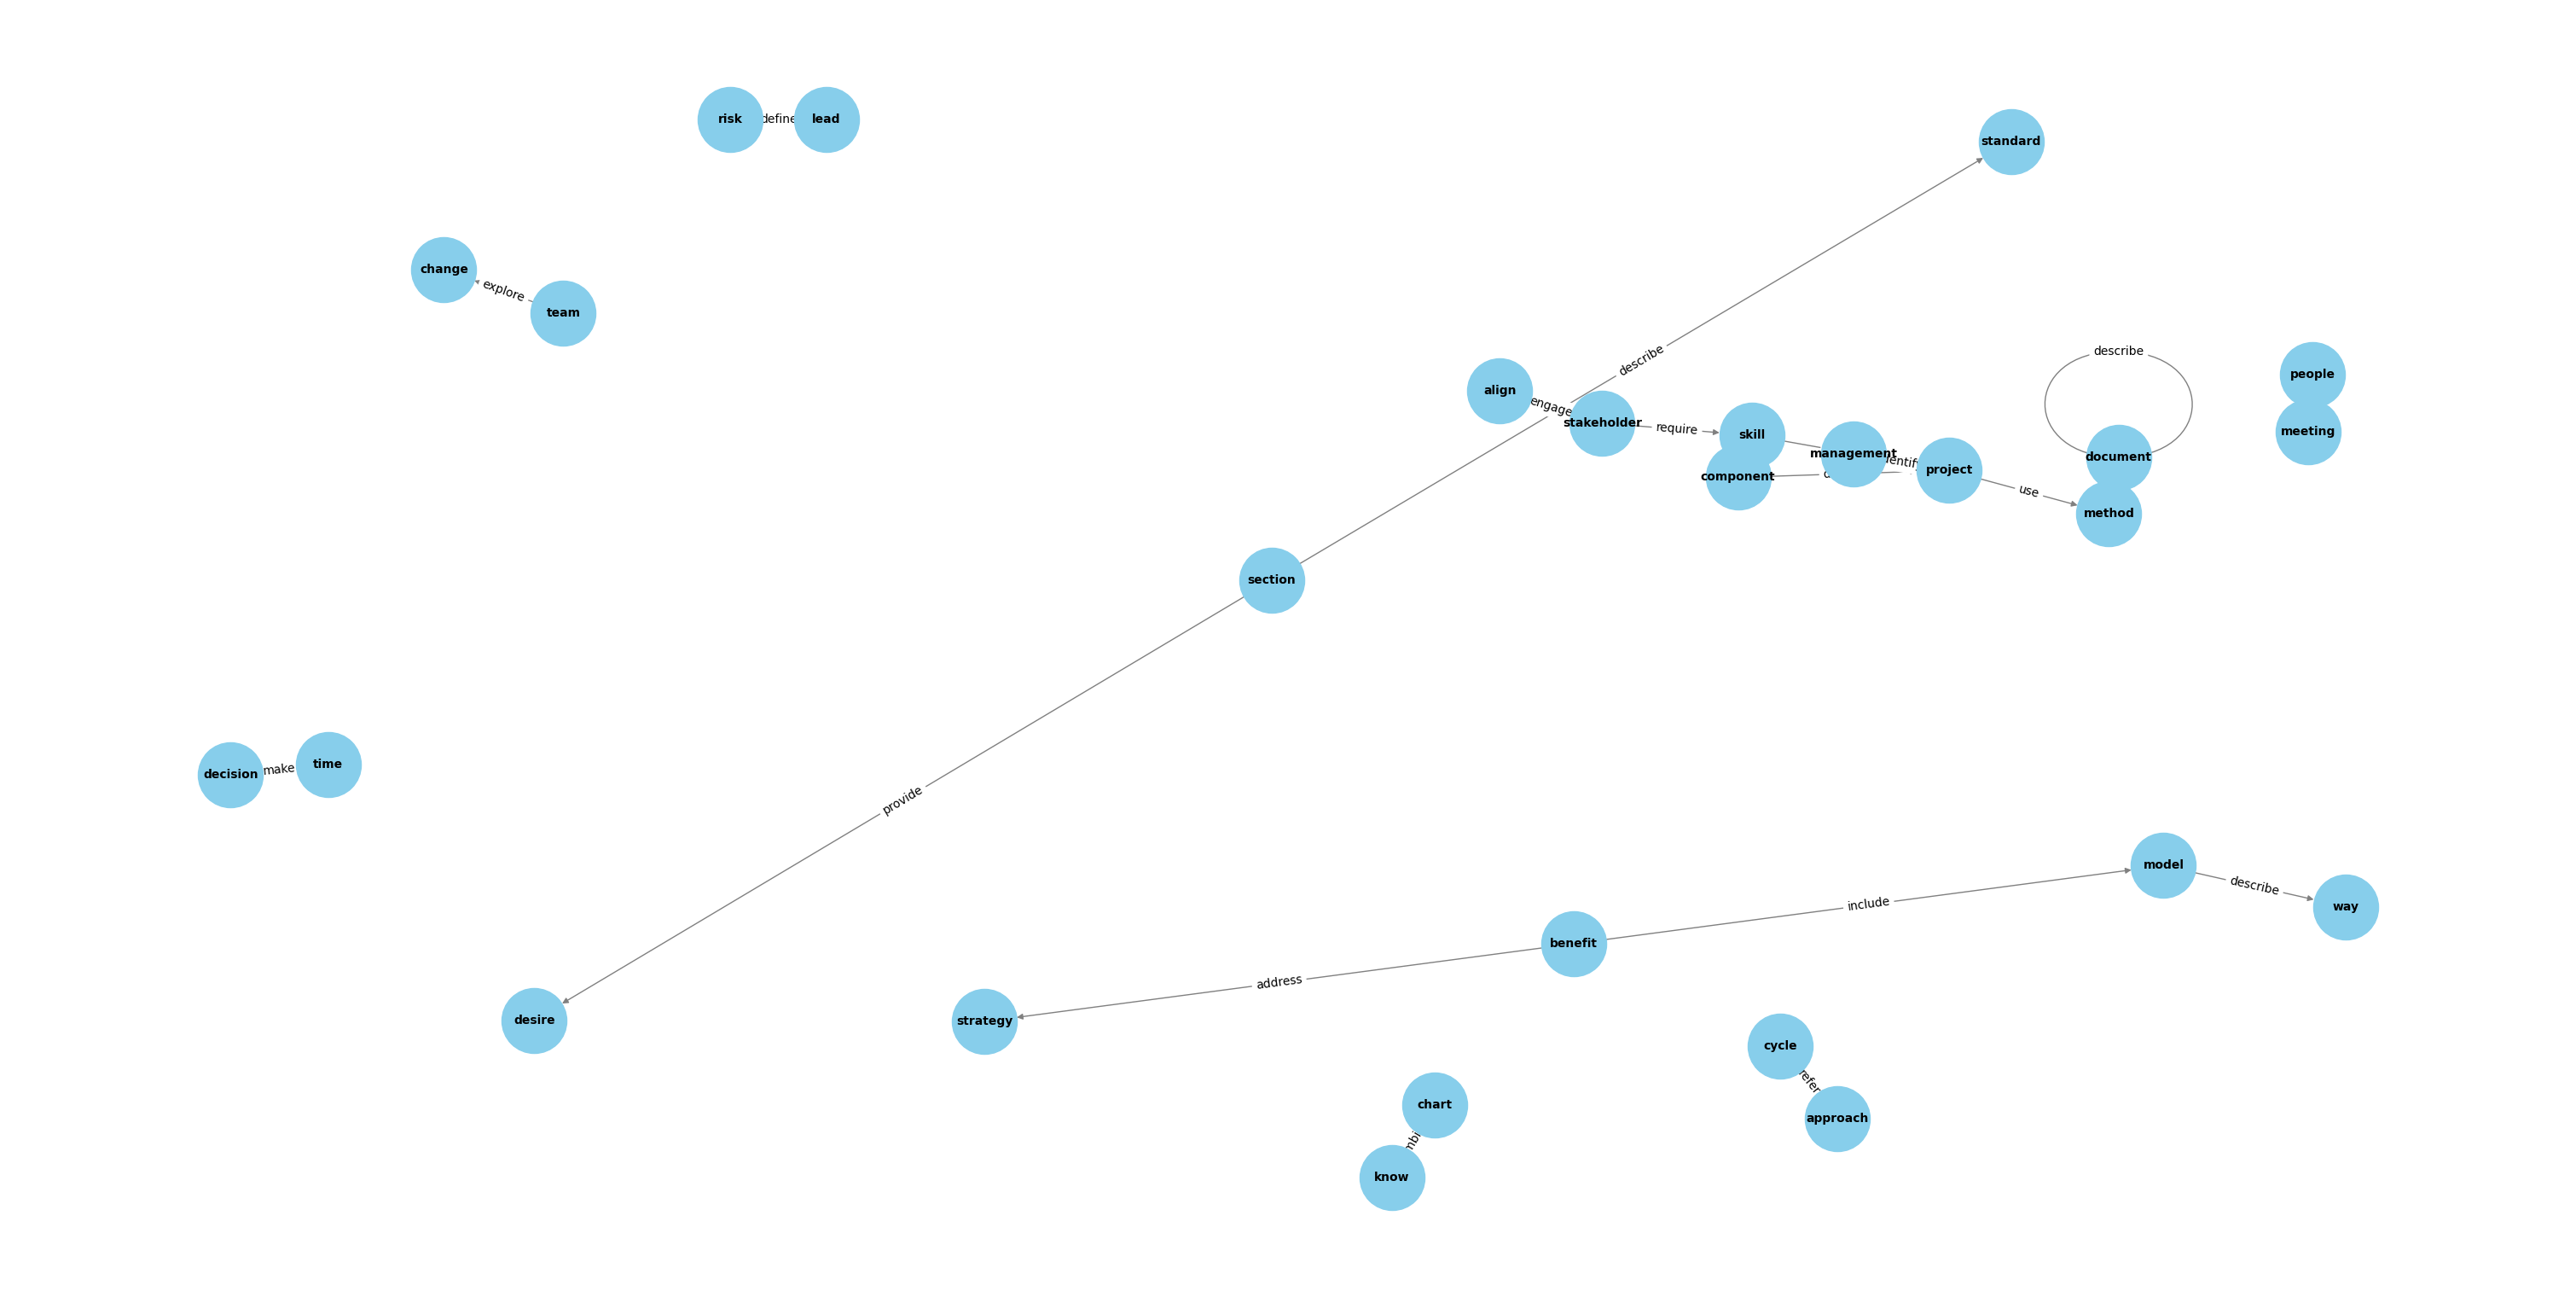

In [101]:
# Step 5b: Construct the knowledge graph using top concepts and filtered relations
knowledge_graph = construct_knowledge_graph(top_concepts, filtered_relations)

# Step 5c: Visualize the knowledge graph
visualize_knowledge_graph(knowledge_graph)

In [12]:
text = raw_text

text = text.lower()
text = re.sub(r'[^a-z\s]', '', text)
doc =nlp(text)

In [15]:
for token in doc:
    print(token.text, token.pos_)


 SPACE
introduction NOUN

 SPACE
the DET
standard NOUN
for ADP
project NOUN
management NOUN
identifies VERB
project NOUN
management NOUN
principles NOUN
that PRON
guide VERB
the DET

 SPACE
behaviors NOUN
and CCONJ
actions NOUN
of ADP
project NOUN
professionals NOUN
and CCONJ
other ADJ
stakeholders NOUN
who PRON
work VERB
on ADP
or CCONJ
are AUX
engaged VERB

 SPACE
with ADP
projects NOUN

 SPACE
this DET
introductory ADJ
section NOUN
describes VERB
the DET
purpose NOUN
of ADP
this DET
standard NOUN
defines VERB
key ADJ
terms NOUN
and CCONJ

 SPACE
concepts NOUN
and CCONJ
identifies VERB
the DET
audience NOUN
for ADP
the DET
standard NOUN

 SPACE
the DET
standard NOUN
for ADP
project NOUN
management NOUN
consists VERB
of ADP
the DET
following VERB
sections NOUN

	
 SPACE
section NOUN
  SPACE
introduction NOUN

	
 SPACE
section NOUN
  SPACE
a DET
system NOUN
for ADP
value NOUN
delivery NOUN

	
 SPACE
section NOUN
  SPACE
project NOUN
management NOUN
principles NOUN

   SPACE
purpose NO

In [13]:
doc[:2000]


introduction
the standard for project management identifies project management principles that guide the 
behaviors and actions of project professionals and other stakeholders who work on or are engaged 
with projects
this introductory section describes the purpose of this standard defines key terms and 
concepts and identifies the audience for the standard
the standard for project management consists of the following sections
	
section  introduction
	
section  a system for value delivery
	
section  project management principles
  purpose of the standard for project management
the standard for project management provides a basis for understanding project management 
and how it enables intended outcomes this standard applies regardless of industry location size 
or delivery approach for example predictive hybrid or adaptive it describes the system within 
which projects operate including governance possible functions the project environment and 
considerations for the relationship betw

In [11]:
doc = nlp(raw_text)

In [12]:
print(len(doc))

107856


In [13]:
doc[0:50]

3
Introduction
The Standard for Project Management identifies project management principles that guide the 
behaviors and actions of project professionals and other stakeholders who work on or are engaged 
with projects.
This introductory section describes the purpose of this standard, defines key terms